In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import os
import json
from typing import Tuple
from tqdm import tqdm
from model_analysis.model_utils import *
from sklearn.metrics import mean_absolute_error

sns.set(rc={"figure.figsize": (20, 10)})


In [2]:
PATH_TO_DATA = "analysis/data/"
FEATURES_TO_USE = json.load(open("model_analysis/selected_features.json", "r"))
REPETITIONS = 10
MODELS_TO_EVALUATE = MODELS.keys()

In [3]:
def df_to_train_data(df: pd.DataFrame) -> Tuple[np.array, np.array]:
    return df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), df.drop(columns=df.columns[:-1], axis=1)

def run_paredoes(index: int) -> pd.DataFrame:
    # Treinando em n-1 paredões para predizer o n-ésimo
    paredoes_df = pd.DataFrame()
    paredoes = len(os.listdir(PATH_TO_DATA))

    for model in tqdm(MODELS_TO_EVALUATE, desc="- Modelos analisados"):
        params = PARAMETERS[model]
        regressor_model = MODELS[model]
        features = FEATURES_TO_USE[model]

        for paredao in range(1, paredoes):
            regressor = regressor_model(**params)
            if NORMALIZE[model]:
                train_df, test_df, mean, std = get_train_test(paredao, features, normalize=True, data_path=PATH_TO_DATA)
            else:
                train_df, test_df = get_train_test(paredao, features, normalize=False,  data_path=PATH_TO_DATA)

            x_train, y_train = df_to_train_data(train_df)
            x_test, y_test = df_to_train_data(test_df)

            y_train, y_test = np.ravel(y_train), np.ravel(y_test)

            regressor.fit(x_train, y_train)
            prediction = regressor.predict(x_test)

            mae = mean_absolute_error(y_test, prediction)
            
            # Making predictions interpretable
            if NORMALIZE[model]:
                test_df["predicao"] = prediction * std + mean
                test_df["rejeicao"] =  test_df["rejeicao"] * std + mean
            else:
                test_df["predicao"] = prediction
            
            pred_elimination, pred_pct = test_df.sort_values(by="predicao", ascending=False)[["nome", "predicao"]].iloc[0] 
            true_elimination, true_pct = test_df.sort_values(by="rejeicao", ascending=False)[["nome", "rejeicao"]].iloc[0]
            
            # renaming for consistence
            model_name = "ensamble1" if model == "ada_boost" else model 

            paredoes_df = paredoes_df.append(
                {
                    "repeticao": index,
                    "paredao": paredao,
                    "eliminado": true_elimination,
                    "rejeicao": true_pct,
                    "mae": mae,
                    "model": model_name,
                    "pred": pred_elimination,
                    "pred_pct": pred_pct
                },
                ignore_index=True
            )

    
    return pd.DataFrame(paredoes_df)

In [4]:
paredoes_analysis_df = run_paredoes(0)
for index in range(1, REPETITIONS): paredoes_analysis_df = paredoes_analysis_df.append(run_paredoes(index), ignore_index=True)

- Modelos analisados: 100%|██████████| 11/11 [00:23<00:00,  2.13s/it]


In [5]:
paredoes_analysis_df.head()

,eliminado,mae,model,paredao,pred,pred_pct,rejeicao,repeticao
0,lucas_chumbo,0.135974,linear_regression,1.0,lucas_chumbo,0.611856,0.7594,0.0
1,petrix,0.254326,linear_regression,2.0,petrix,0.421703,0.8027,0.0
2,hadson,0.281457,linear_regression,3.0,hadson,0.529758,0.7971,0.0
3,lucas,0.245262,linear_regression,4.0,lucas,0.518124,0.6262,0.0
4,bianca_andrade,0.128988,linear_regression,5.0,felipe_prior,0.424497,0.5309,0.0


# Contagem de acertos

In [6]:
paredoes_analysis_df["mean_absolute_error"] = abs(paredoes_analysis_df["rejeicao"] - paredoes_analysis_df["pred_pct"])
paredoes_analysis_df["correct"] = paredoes_analysis_df["eliminado"] == paredoes_analysis_df["pred"]

In [7]:
paredoes_analysis_df[paredoes_analysis_df["repeticao"] == 0]

,eliminado,mae,model,paredao,pred,pred_pct,rejeicao,repeticao,mean_absolute_error,correct
0,lucas_chumbo,0.135974,linear_regression,1.0,lucas_chumbo,0.611856,0.7594,0.0,0.147544,True
1,petrix,0.254326,linear_regression,2.0,petrix,0.421703,0.8027,0.0,0.380997,True
2,hadson,0.281457,linear_regression,3.0,hadson,0.529758,0.7971,0.0,0.267342,True
3,lucas,0.245262,linear_regression,4.0,lucas,0.518124,0.6262,0.0,0.108076,True
4,bianca_andrade,0.128988,linear_regression,5.0,felipe_prior,0.424497,0.5309,0.0,0.106403,False
...,...,...,...,...,...,...,...,...,...,...
182,flayslene,0.077396,ensamble2,13.0,flayslene,0.565390,0.6300,0.0,0.064610,True
183,gizelly_bicalho,0.047938,ensamble2,14.0,gizelly_bicalho,0.512013,0.5479,0.0,0.035887,True
184,ivy,0.256612,ensamble2,15.0,ivy,0.478272,0.7417,0.0,0.263428,True
185,mari,0.068308,ensamble2,16.0,mari,0.485866,0.5416,0.0,0.055734,True


In [8]:
paredoes_analysis_df.to_csv("paredoes.csv")

In [9]:
resultados_medios = paredoes_analysis_df.groupby(["model", "paredao"]).mean()
resultados_medios["average_hits"] = paredoes_analysis_df[["model", "paredao", "correct"]].groupby(["model", "paredao"]).sum().values
resultados_medios.drop(["repeticao", "rejeicao"], axis=1, inplace=True)
resultados_medios.reset_index(inplace=True)


In [10]:
resultados_medios

,model,paredao,mae,pred_pct,mean_absolute_error,correct,average_hits
0,elastic_net,1.0,0.232023,0.398654,0.360746,1.0,10.0
1,elastic_net,2.0,0.322615,0.401393,0.401307,1.0,10.0
2,elastic_net,3.0,0.333920,0.329599,0.467501,1.0,10.0
3,elastic_net,4.0,0.248783,0.403705,0.222495,1.0,10.0
4,elastic_net,5.0,0.156788,0.351693,0.179207,0.0,0.0
...,...,...,...,...,...,...,...
182,svr,13.0,0.065812,0.567151,0.062849,1.0,10.0
183,svr,14.0,0.052933,0.585637,0.037737,1.0,10.0
184,svr,15.0,0.257455,0.442289,0.299411,1.0,10.0
185,svr,16.0,0.062867,0.480419,0.061181,1.0,10.0


In [11]:
acertos_medios = resultados_medios[["model", "average_hits"]].groupby("model").sum()
acertos_medios /= REPETITIONS

In [12]:
acertos_medios.sort_values(by="average_hits", ascending=False)

,average_hits
model,
ensamble3,16.0
ridge,14.0
svr,14.0
ensamble2,13.7
ensamble1,13.5
random_forest,13.4
sgd,13.3
knn,13.0
lasso,11.0


In [13]:
acertos_medios.sort_values(by="average_hits", inplace=True)

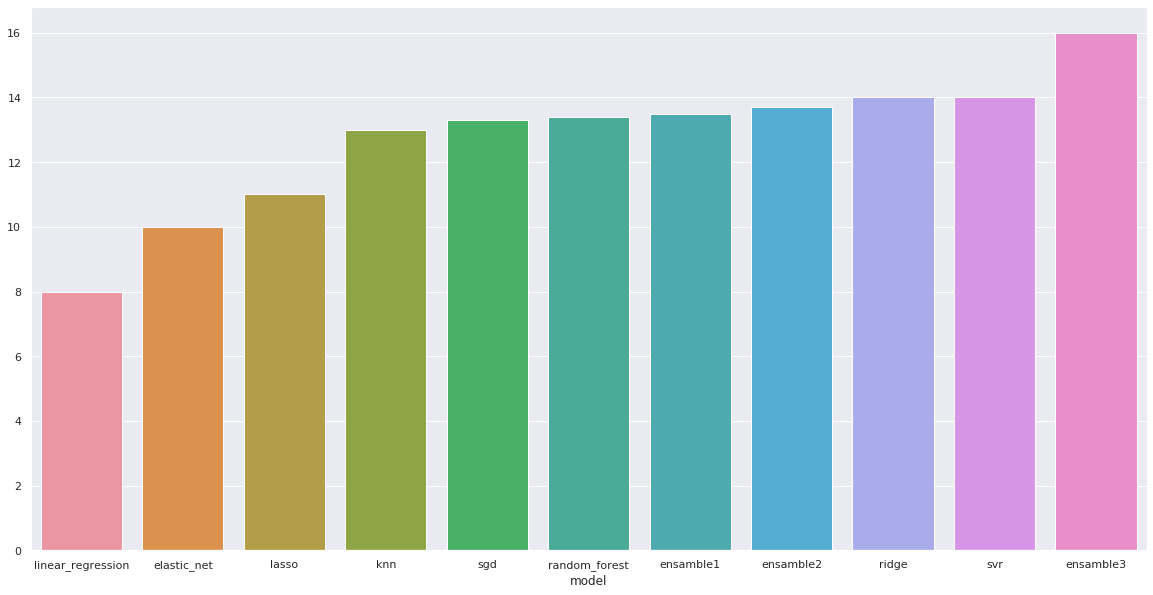

In [14]:
sns.barplot(x=acertos_medios.index, y=acertos_medios["average_hits"].values)

# Análise de erro absoluto por paredão

In [15]:
resultados_medios.sort_values(by="paredao", inplace=True)
erro_df = resultados_medios.set_index("paredao").pivot(columns="model")


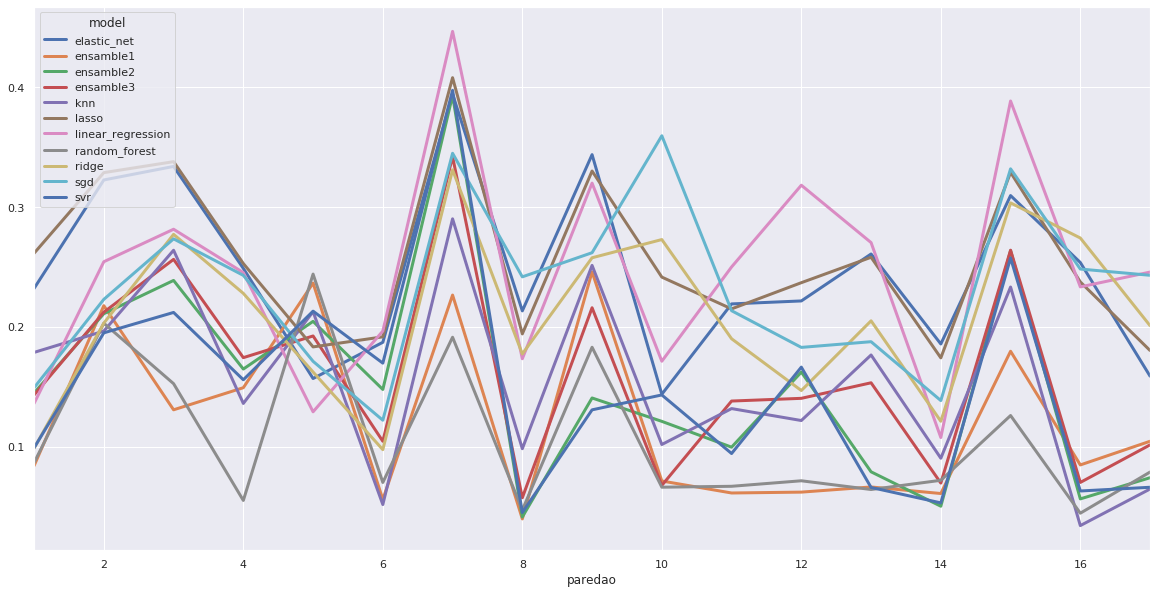

In [16]:
erro_df["mae"].plot(linewidth=3)

# Acertos em cada paredão

In [17]:
paredoes_analysis_df.head()

,eliminado,mae,model,paredao,pred,pred_pct,rejeicao,repeticao,mean_absolute_error,correct
0,lucas_chumbo,0.135974,linear_regression,1.0,lucas_chumbo,0.611856,0.7594,0.0,0.147544,True
1,petrix,0.254326,linear_regression,2.0,petrix,0.421703,0.8027,0.0,0.380997,True
2,hadson,0.281457,linear_regression,3.0,hadson,0.529758,0.7971,0.0,0.267342,True
3,lucas,0.245262,linear_regression,4.0,lucas,0.518124,0.6262,0.0,0.108076,True
4,bianca_andrade,0.128988,linear_regression,5.0,felipe_prior,0.424497,0.5309,0.0,0.106403,False


In [24]:
paredoes_analysis_df["paredao"] = paredoes_analysis_df["paredao"].astype(int)

In [25]:
paredoes_df = paredoes_analysis_df[["paredao", "model", "correct"]].groupby(["paredao", "model"]).sum()

In [26]:
paredoes_df.reset_index(inplace=True)
paredoes_df = paredoes_df.groupby("paredao").mean()

In [27]:
paredoes_df

,correct
paredao,
1,10.000000
2,10.000000
3,10.000000
4,9.545455
5,0.000000
6,9.090909
7,5.454545
8,7.727273
9,10.000000


In [28]:
paredoes_df = paredoes_df.groupby("paredao").mean()
paredoes_df.sort_index(inplace=True, ascending=False)

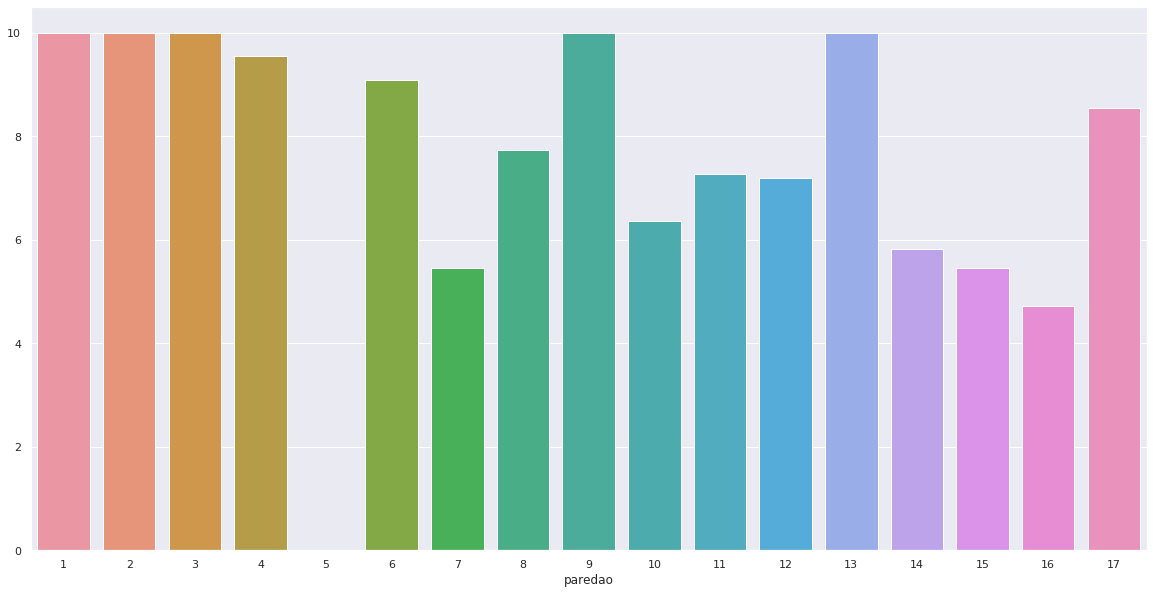

In [29]:
sns.barplot(x=paredoes_df.index, y=paredoes_df["correct"].values)